In [1]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
from sklearn.decomposition import PCA 
from sklearn.preprocessing import *
import numpy as np
from sklearn.feature_selection import *
import librosa

In [2]:
# paths for the data

DATA_PATH = "/kaggle/input/fma-small/"
METADATA_PATH = DATA_PATH + "fma_metadata/fma_metadata/"
FMA_SMALL_PATH = DATA_PATH + "fma_small/fma_small/"
FIG_SIZE = (10, 5)

In [3]:
os.listdir(METADATA_PATH)

['echonest.csv',
 'raw_genres.csv',
 'raw_artists.csv',
 'features.csv',
 'genres.csv',
 'README.txt',
 'not_found.pickle',
 'tracks.csv',
 'raw_tracks.csv',
 'raw_albums.csv',
 'raw_echonest.csv',
 'checksums']

In [4]:
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all'),
                   ('track', 'genres_top')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                'category', categories=SUBSETS, ordered=True)

        COLUMNS = [('track', 'license'), ('artist', 'bio'),
                   ('album', 'type'), ('album', 'information')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks

In [5]:
filepath = METADATA_PATH + 'tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                        ...       track                         \
         producer tags  ... information interest language_code   
track_id                ...                                      
2             NaN   []  ...         NaN     4656            en   
3             NaN   []  ...         NaN     1470            en   
5             NaN   []  ...         NaN     1933            en   
10            NaN   []  ...         NaN    54881            en   
20            NaN   []  ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [6]:
tracks.columns

MultiIndex([( 'album',          'comments'),
            ( 'album',      'date_created'),
            ( 'album',     'date_released'),
            ( 'album',          'engineer'),
            ( 'album',         'favorites'),
            ( 'album',                'id'),
            ( 'album',       'information'),
            ( 'album',           'listens'),
            ( 'album',          'producer'),
            ( 'album',              'tags'),
            ( 'album',             'title'),
            ( 'album',            'tracks'),
            ( 'album',              'type'),
            ('artist', 'active_year_begin'),
            ('artist',   'active_year_end'),
            ('artist', 'associated_labels'),
            ('artist',               'bio'),
            ('artist',          'comments'),
            ('artist',      'date_created'),
            ('artist',         'favorites'),
            ('artist',                'id'),
            ('artist',          'latitude'),
          

In [7]:
# information or features about the album.
tracks["album"]

,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance
155317,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance
155318,0,2017-03-30 15:20:35,2017-02-17 00:00:00,NaN,0,22940,"<p>A live performance at Monty Hall on Feb 17,...",1506,Monty Hall,[],"Live at Monty Hall, 2/17/2017",6,Live Performance


In [8]:
# Training testing validation split for subset of data.
tracks["set"]

,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large
...,...,...
155316,training,large
155317,training,large
155318,training,large


In [9]:
tracks["artist"]

,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN
10,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN
20,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN
155317,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN
155318,NaN,NaN,NaN,NaN,0,2017-03-30 15:18:28,0,24357,NaN,New Jersey,NaN,GILLIAN/JENNA/DECLAN/JAIME,Spowder,NaN,['spowder'],https://spowder.bandcamp.com/,NaN


In [10]:
tracks["track"]

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155316,320000,0,NaN,2017-03-30 15:23:34,NaN,162,1,Rock,[25],"[25, 12]",NaN,122,NaN,Creative Commons Attribution-NonCommercial-NoD...,102,NaN,3,NaN,[],The Auger
155317,320000,0,NaN,2017-03-30 15:23:36,NaN,217,1,Rock,[25],"[25, 12]",NaN,194,NaN,Creative Commons Attribution-NonCommercial-NoD...,165,NaN,4,NaN,[],Let's Skin Ruby
155318,320000,0,NaN,2017-03-30 15:23:37,NaN,404,2,Rock,[25],"[25, 12]",NaN,214,NaN,Creative Commons Attribution-NonCommercial-NoD...,168,NaN,6,NaN,[],My House Smells Like Kim Deal/Pulp


In [11]:
filepath = METADATA_PATH + 'features.csv'
features = load(filepath)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [12]:
features.columns

MultiIndex([('chroma_cens', 'kurtosis', '01'),
            ('chroma_cens', 'kurtosis', '02'),
            ('chroma_cens', 'kurtosis', '03'),
            ('chroma_cens', 'kurtosis', '04'),
            ('chroma_cens', 'kurtosis', '05'),
            ('chroma_cens', 'kurtosis', '06'),
            ('chroma_cens', 'kurtosis', '07'),
            ('chroma_cens', 'kurtosis', '08'),
            ('chroma_cens', 'kurtosis', '09'),
            ('chroma_cens', 'kurtosis', '10'),
            ...
            (    'tonnetz',      'std', '04'),
            (    'tonnetz',      'std', '05'),
            (    'tonnetz',      'std', '06'),
            (        'zcr', 'kurtosis', '01'),
            (        'zcr',      'max', '01'),
            (        'zcr',     'mean', '01'),
            (        'zcr',   'median', '01'),
            (        'zcr',      'min', '01'),
            (        'zcr',     'skew', '01'),
            (        'zcr',      'std', '01')],
           names=['feature', 'statistics', 

In [13]:
# These are features of the tracks, features about the time and frequency domain

print('{1} features for {0} tracks'.format(*features.shape))
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
for column in columns:
    print("Column: ", column)
    ipd.display(features[column].head().style.format('{:.2f}'))

518 features for 106574 tracks
Column:  mfcc


Column:  chroma_cens


Column:  tonnetz


Column:  spectral_contrast


Column:  ['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff']


Column:  ['rmse', 'zcr']


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


((5631, 2), (5631,))

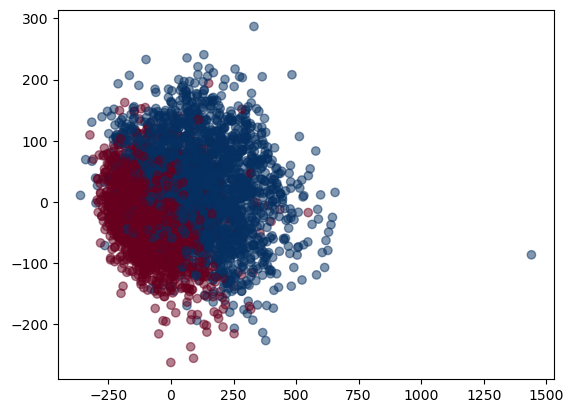

In [14]:
# visualizing the mfcc 

small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

X = features.loc[small & (genre1 | genre2), 'mfcc']
X = PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [15]:
# Genres in the dataset .

filepath = METADATA_PATH + "genres.csv"
genres = load(filepath)
genres.head(10)

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
6,914,38,Novelty,38
7,217,20,Comedy,20
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9


In [16]:
# Audio

filename = FMA_SMALL_PATH + "001/001102.mp3"
print('File: {}'.format(filename))

x, sr = librosa.load(filename, sr=None, mono=True)
print('Duration: {:.2f}s, {} samples'.format(x.shape[-1] / sr, x.size))

start, end = 7, 17
ipd.Audio(data=x[start*sr:end*sr], rate=sr)

File: /kaggle/input/fma-small/fma_small/fma_small/001/001102.mp3


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Duration: 30.00s, 1323119 samples


# **Waveform of the audio**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Text(0.5, 1.0, 'Waveform')

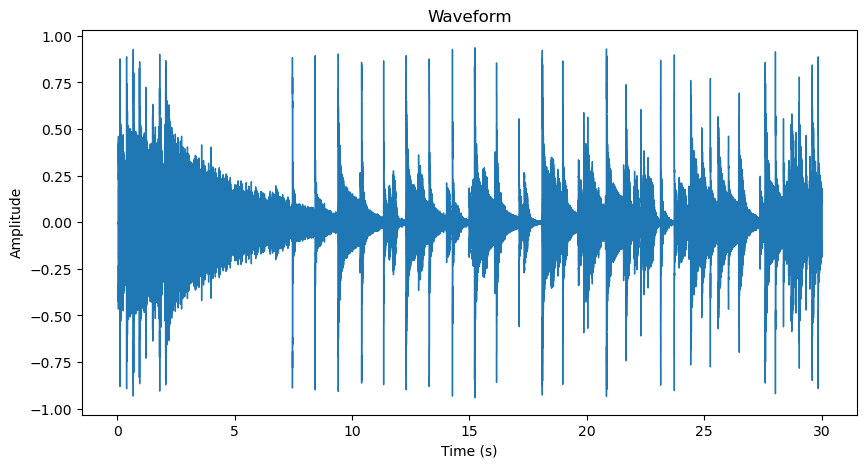

In [17]:
signal, sample_rate = librosa.load(filename, sr=22050)

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

# **Fourier Transform**

Text(0.5, 1.0, 'Power spectrum')

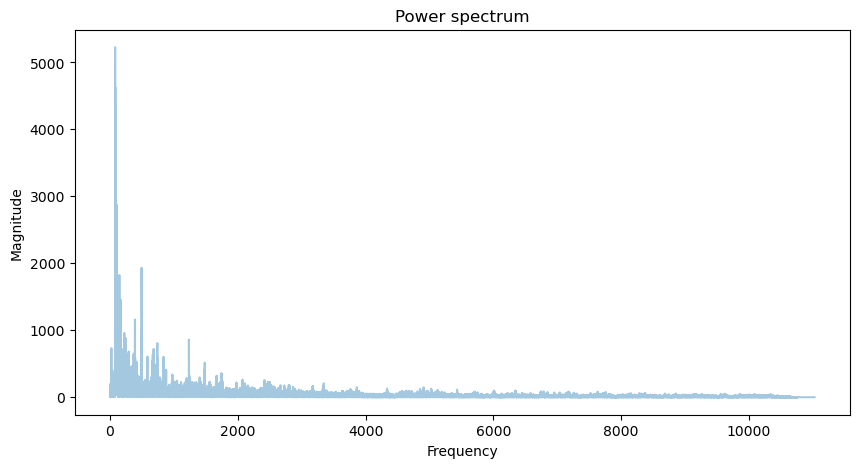

In [18]:
fft = np.fft.fft(signal)

# calculate abs values on complex numbers to get magnitude
spectrum = np.abs(fft)

# create frequency variable
f = np.linspace(0, sample_rate, len(spectrum))

# take half of the spectrum and frequency
left_spectrum = spectrum[:int(len(spectrum)/2)]
left_f = f[:int(len(spectrum)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

# **STFT (Short Time Fourier Transform)**

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram (dB)')

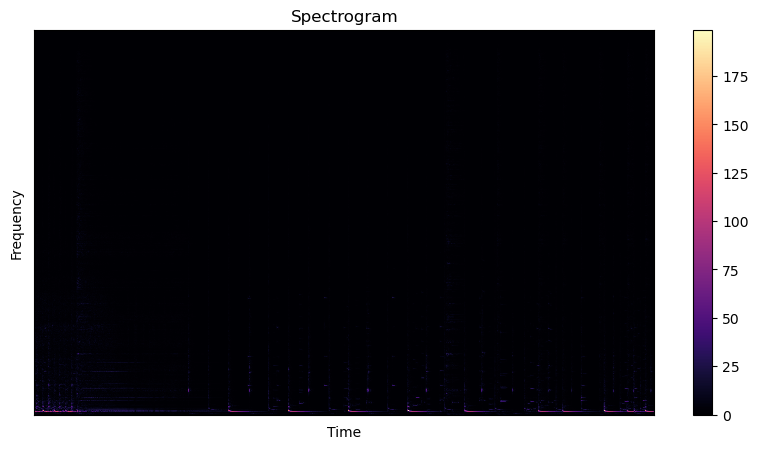

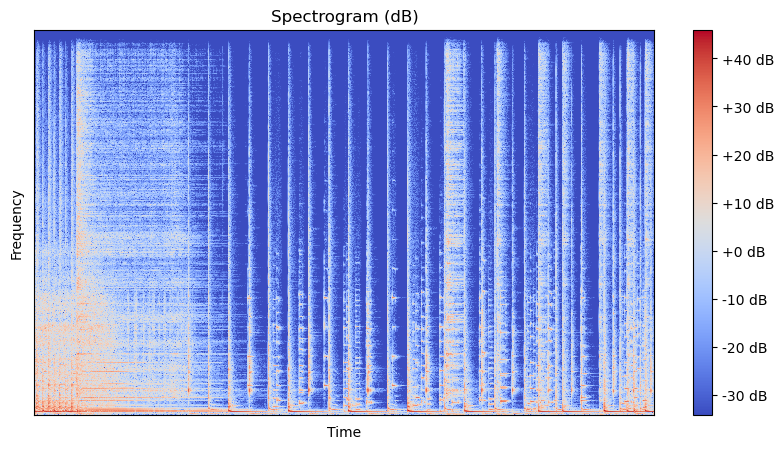

In [19]:
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

# display spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")

# apply logarithm to cast amplitude to Decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

# **MFCC (Mel Frequency Cepstral Coefficients)**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


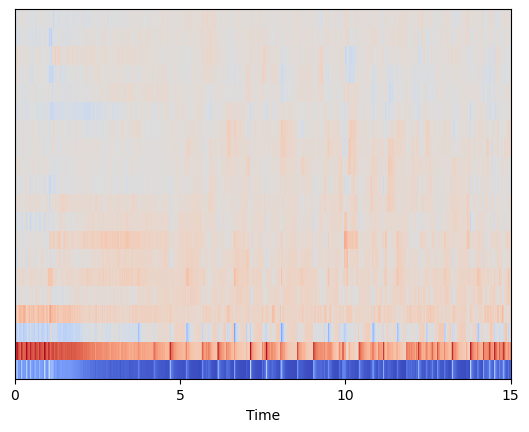

In [20]:
# extract 13 MFCCs
mel = librosa.feature.melspectrogram(sr=sr, S=stft**2)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
mfcc = StandardScaler().fit_transform(mfcc)
librosa.display.specshow(mfcc, sr=sr, x_axis='time');

In [21]:
cols_needed = [("set", "subset"), ("set", "split"), ("track", "genre_top"), ("track", "genres")]
tracks = tracks[cols_needed]

tracks.head(10)

set               track           
          subset     split genre_top     genres
track_id                                       
2          small  training   Hip-Hop       [21]
3         medium  training   Hip-Hop       [21]
5          small  training   Hip-Hop       [21]
10         small  training       Pop       [10]
20         large  training       NaN  [76, 103]
26         large  training       NaN  [76, 103]
30         large  training       NaN  [76, 103]
46         large  training       NaN  [76, 103]
48         large  training       NaN  [76, 103]
134       medium  training   Hip-Hop       [21]

In [22]:
feature_columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast', 
                           'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'rmse', 'zcr']

features = features[feature_columns]

In [23]:
small = tracks['set', 'subset'] == 'small'

train = tracks['set', 'split'] == 'training'
val = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

train_y = tracks.loc[small & train, ('track', 'genre_top')]
val_y = tracks.loc[small & val, ('track', 'genre_top')]
test_y = tracks.loc[small & test, ('track', 'genre_top')]

train_X = features.loc[small & train]
val_X = features.loc[small & val]
test_X = features.loc[small & test]

print('{} training samples, {} testing samples'.format(train_y.size, val_y.size))
print('{} features, {} classes'.format(train_X.shape[1], np.unique(train_y).size))

6400 training samples, 800 testing samples
350 features, 8 classes


In [24]:
importances = mutual_info_classif(train_X, train_y)

<AxesSubplot:ylabel='feature,statistics,number'>

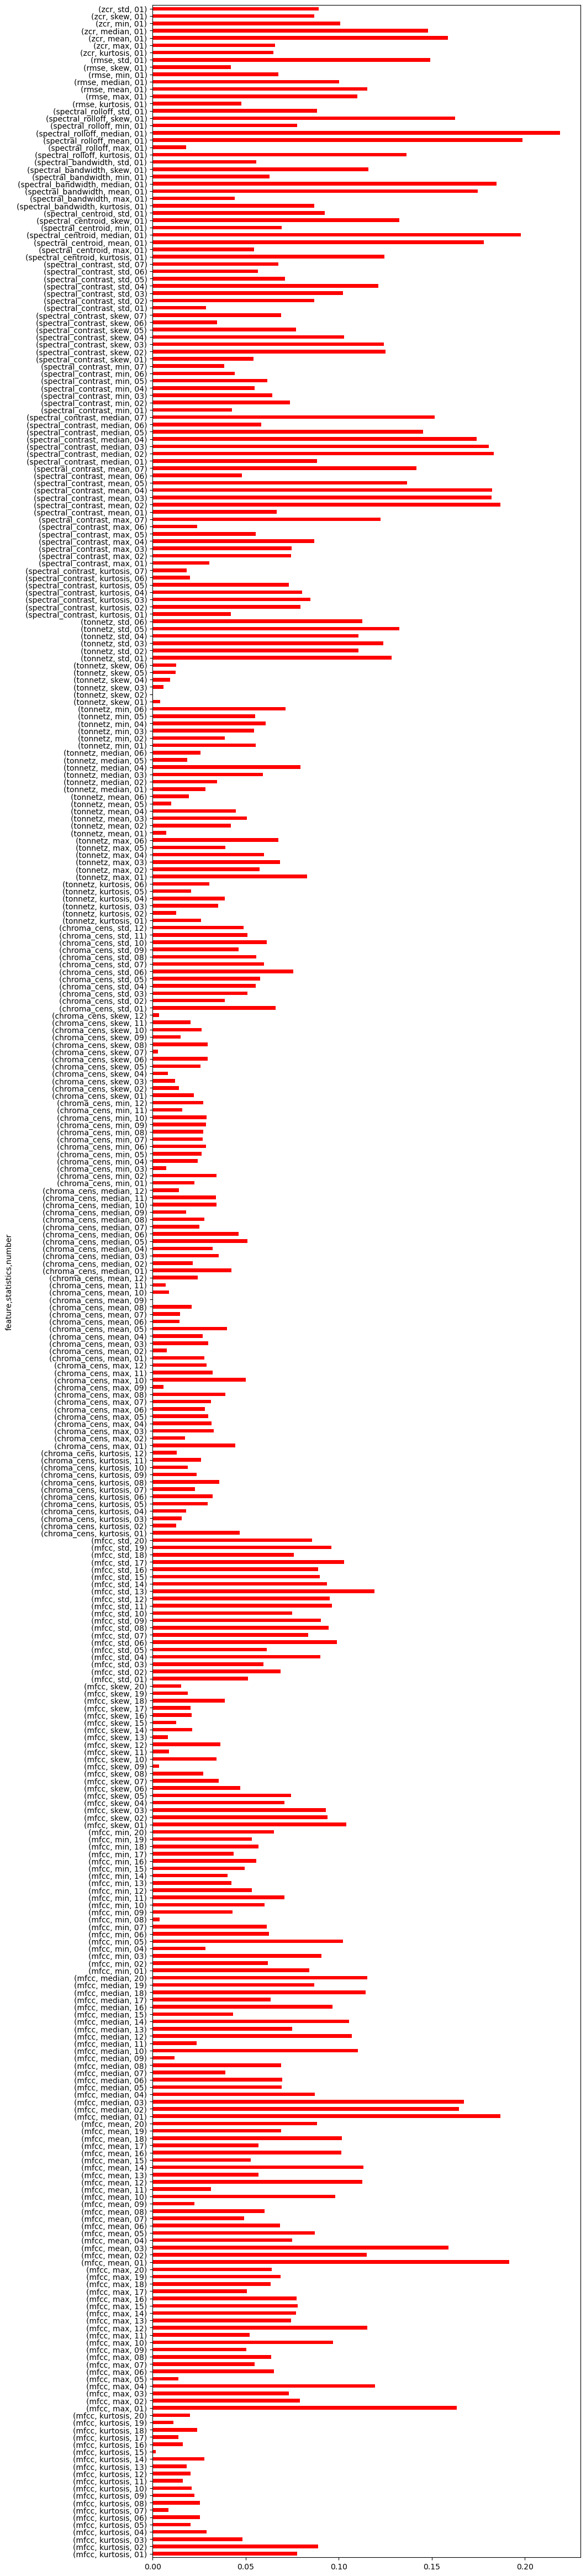

In [25]:
fea_importances = pd.Series(importances, train_X.columns[0: len(train_X)-1])
fea_importances.plot(color="red", kind="barh", figsize=(10, 60))

In [26]:
# Selecting top 100 for model building

imp_features = fea_importances.sort_values(ascending=False)[:250]

In [152]:
train_X = train_X[imp_features.index]
test_X = test_X[imp_features.index]
val_X = val_X[imp_features.index]

In [27]:
def _scale(X, y):
    scaler = StandardScaler()
    scaler.fit(X, y)
    scaled_X = scaler.transform(X)
    return scaled_X

scaled_train_X = _scale(train_X, train_y)
scaled_val_X = _scale(val_X, val_y)
scaled_test_X = _scale(test_X, test_y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.

In [28]:
scaled_train_X.shape

(6400, 350)

In [29]:
import time 
from sklearn.linear_model import * 
from sklearn.svm import SVC 
from sklearn.ensemble import *
from sklearn.metrics import *

class Metrics: 
    def __init__(self, preds_y, true_y, labels_name, avg_method):
        self.preds_y = preds_y 
        self.true_y = true_y 
        self.labels_name = labels_name 
        self.avg_method = avg_method 
        
    @property 
    def report(self): 
        report = classification_report(self.true_y, self.preds_y, target_names=self.labels_name)
        return report 
    
    @property
    def f1score(self):
        res = f1_score(self.true_y, self.preds_y, average=self.avg_method)
        return res 
    
    @property
    def cohen_kappa(self): 
        res = cohen_kappa_score(self.true_y, self.preds_y)
        return res 
    
    @property
    def precision(self): 
        res = precision_score(self.true_y, self.preds_y, average=self.avg_method)
        return res
    
    @property
    def recall(self): 
        res = recall_score(self.true_y, self.preds_y, average=self.avg_method)
        return res
    
    @property
    def accuracy(self): 
        res = accuracy_score(self.true_y, self.preds_y)
        return res
    
    @property
    def confusion_matrix(self): 
        res = confusion_matrix(self.true_y, self.preds_y)
        return res
        
        
def train_classifier(train_X, train_y, clf): 
    clf.fit(train_X, train_y)
    return clf


def _predict(clf, test_X): 
    preds_y = clf.predict(test_X)
    return preds_y 

# **Logistic Regression**

In [30]:
logistic_reg = LogisticRegression(max_iter=10000)
trained_logistic_reg = train_classifier(scaled_train_X, train_y, logistic_reg)

In [31]:
preds_y = _predict(trained_logistic_reg, scaled_test_X)
preds_y_train = _predict(trained_logistic_reg, scaled_train_X)

In [32]:
labels_name = np.unique(train_y)
metrics = Metrics(test_y, preds_y, labels_name, "average")
train_metrics = Metrics(train_y, preds_y_train, labels_name, "average")

Classification Report on training data; 
               precision    recall  f1-score   support

   Electronic       0.69      0.70      0.69       790
 Experimental       0.61      0.65      0.63       748
         Folk       0.77      0.75      0.76       815
      Hip-Hop       0.78      0.73      0.75       854
 Instrumental       0.73      0.71      0.72       816
International       0.73      0.72      0.73       815
          Pop       0.51      0.57      0.54       723
         Rock       0.76      0.73      0.75       839

     accuracy                           0.70      6400
    macro avg       0.70      0.69      0.70      6400
 weighted avg       0.70      0.70      0.70      6400

Classification Report on training data; 
               precision    recall  f1-score   support

   Electronic       0.42      0.47      0.44        89
 Experimental       0.38      0.33      0.35       116
         Folk       0.14      0.19      0.16        73
      Hip-Hop       0.69      0.55

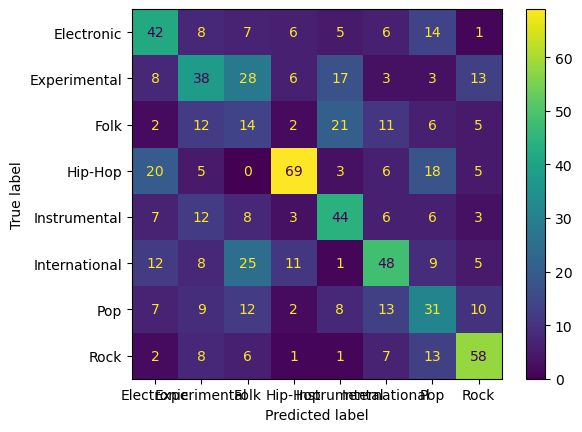

In [33]:
print("Classification Report on training data; ")
print(train_metrics.report)

print("Classification Report on training data; ")
print(metrics.report)

print("Cohen Kappa: ")
print(metrics.cohen_kappa, "\n")

print("Accuracy: ")
print(metrics.accuracy, "\n")

confusion_ma = metrics.confusion_matrix
cm_display =  ConfusionMatrixDisplay(confusion_matrix = confusion_ma, display_labels = labels_name)
cm_display.plot()
plt.show()

# **SVM**

In [34]:
svc = SVC()
trained_svc = train_classifier(scaled_train_X, train_y, svc)

In [35]:
preds_y = _predict(trained_svc, scaled_test_X)
preds_y_train = _predict(trained_svc, scaled_train_X)
labels_name = np.unique(train_y)
metrics = Metrics(test_y, preds_y, labels_name, "average")
train_metrics = Metrics(train_y, preds_y_train, labels_name, "average")

Classification Report on training data; 
               precision    recall  f1-score   support

   Electronic       0.86      0.84      0.85       823
 Experimental       0.79      0.85      0.82       744
         Folk       0.85      0.82      0.84       825
      Hip-Hop       0.89      0.80      0.84       886
 Instrumental       0.84      0.85      0.84       790
International       0.84      0.85      0.85       785
          Pop       0.71      0.77      0.74       731
         Rock       0.83      0.82      0.83       816

     accuracy                           0.83      6400
    macro avg       0.83      0.83      0.83      6400
 weighted avg       0.83      0.83      0.83      6400

Classification Report; 
               precision    recall  f1-score   support

   Electronic       0.59      0.55      0.57       107
 Experimental       0.45      0.36      0.40       124
         Folk       0.20      0.21      0.21        94
      Hip-Hop       0.75      0.62      0.68       

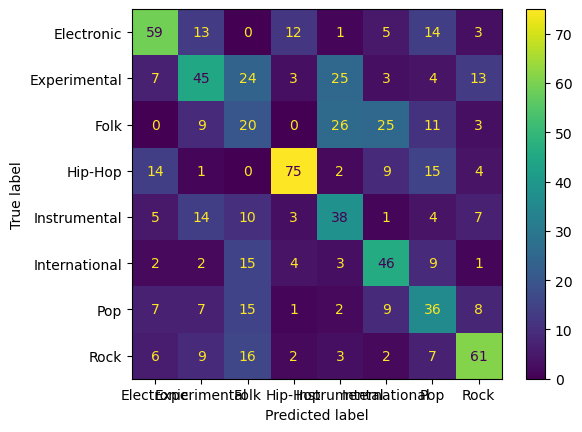

In [36]:
print("Classification Report on training data; ")
print(train_metrics.report)

print("Classification Report; ")
print(metrics.report)

print("Cohen Kappa: ")
print(metrics.cohen_kappa, "\n")

print("Accuracy: ")
print(metrics.accuracy, "\n")

confusion_ma = metrics.confusion_matrix
cm_display =  ConfusionMatrixDisplay(confusion_matrix = confusion_ma, display_labels = labels_name)
cm_display.plot()
plt.show()

# **Random Forest**

In [37]:
rf = RandomForestClassifier(random_state=10, max_depth=30, n_estimators=500, min_samples_leaf=6, min_impurity_decrease=0.0002,
                     class_weight='balanced')
trained_rf = train_classifier(scaled_train_X, train_y, rf)

In [38]:
preds_y = _predict(trained_rf, scaled_test_X)
preds_y_train = _predict(trained_rf, scaled_train_X)
labels_name = np.unique(train_y)
metrics = Metrics(test_y, preds_y, labels_name, "average")
train_metrics = Metrics(train_y, preds_y_train, labels_name, "average")

Classification Report on training data; 
               precision    recall  f1-score   support

   Electronic       0.94      0.95      0.95       786
 Experimental       0.91      0.97      0.94       756
         Folk       0.95      0.92      0.93       830
      Hip-Hop       0.98      0.95      0.96       825
 Instrumental       0.94      0.88      0.91       855
International       0.95      0.98      0.97       776
          Pop       0.93      0.99      0.96       747
         Rock       0.94      0.91      0.93       825

     accuracy                           0.94      6400
    macro avg       0.94      0.94      0.94      6400
 weighted avg       0.94      0.94      0.94      6400

Classification Report; 
               precision    recall  f1-score   support

   Electronic       0.65      0.50      0.57       130
 Experimental       0.23      0.28      0.25        82
         Folk       0.26      0.24      0.25       108
      Hip-Hop       0.68      0.59      0.63       

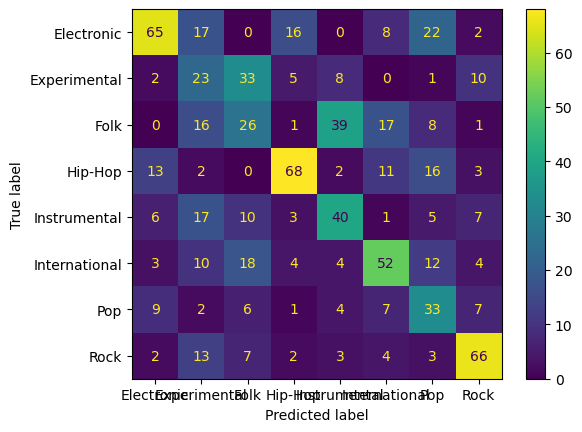

In [39]:
print("Classification Report on training data; ")
print(train_metrics.report)

print("Classification Report; ")
print(metrics.report)

print("Cohen Kappa: ")
print(metrics.cohen_kappa, "\n")

print("Accuracy: ")
print(metrics.accuracy, "\n")

confusion_ma = metrics.confusion_matrix
cm_display =  ConfusionMatrixDisplay(confusion_matrix = confusion_ma, display_labels = labels_name)
cm_display.plot()
plt.show()

In [40]:
BATCH_SIZE = 32

In [41]:
import tensorflow as tf 
import tensorflow.keras as keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam 

In [57]:
class DNNModel(keras.models.Model): 
    def __init__(self, input_dims, out_dims): 
        super(DNNModel, self).__init__()
        self.input_dims = input_dims 
        self.out_dims = out_dims 
        
        self.inp = Input(shape=self.input_dims)
        self.dense1 = Dense(128, activation='relu', kernel_initializer="he_uniform")
        self.dense2 = Dense(64, activation='relu', kernel_initializer="he_uniform")
        self.dense3 = Dense(32, activation='relu', kernel_initializer="he_uniform")
        self.out = Dense(self.out_dims)
        
    def call(self, tensor): 
        #x = self.inp(tensor)
        x = self.dense1(tensor)
        x = self.dense2(x)
        x = self.dense3(x)
        out = self.out(x)
        
        return out

#@tf.function
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
     #   print(y, "y")
        logits = model(x, training=True)
        y = tf.reshape(y, (32, 8))
        loss_value = loss_fn(y, logits)
    
    params =  model.trainable_weights
    grads = tape.gradient(loss_value, params)
    optimizer.apply_gradients(zip(grads, params))

    train_acc_metric.update_state(y, logits)

    return loss_value

#@tf.function
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [63]:
import tqdm

def train(train_dataset,
          val_dataset, 
          model,
          optimizer,
          loss_fn,
          train_acc_metric,
          val_acc_metric,
          epochs=20
          , 
          log_step=200, 
          val_log_step=50):
  
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(x_batch_train, y_batch_train, 
                                    model, optimizer, 
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val, 
                                       model, loss_fn, 
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        val_acc = val_acc_metric.result()
        
        print("Training acc over epoch: %.4f" % (float(train_acc),), "Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()


In [69]:
train_y_ =  tf.convert_to_tensor(pd.get_dummies(train_y))
test_y_ =  tf.convert_to_tensor(pd.get_dummies(test_y))
val_y_ =  tf.convert_to_tensor(pd.get_dummies(val_y))

In [65]:
train_y_.shape

TensorShape([6400, 8])

In [70]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_train_X, train_y_))
train_dataset = (train_dataset.shuffle(buffer_size=1024)
                                  .batch(BATCH_SIZE)
                                  .prefetch(buffer_size=tf.data.AUTOTUNE))

val_dataset = tf.data.Dataset.from_tensor_slices((scaled_val_X, val_y_))
val_dataset = (val_dataset.batch(BATCH_SIZE)
                              .prefetch(buffer_size=tf.data.AUTOTUNE))

In [71]:
dnn_model = DNNModel(scaled_train_X.shape[1], len(np.unique(train_y)))
opt = Adam(learning_rate=0.001)
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
test_loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
train_acc_function = tf.keras.metrics.CategoricalAccuracy()
test_acc_function = tf.keras.metrics.CategoricalAccuracy()

In [72]:
train(train_dataset, val_dataset, dnn_model, opt, loss_function, train_acc_function, test_acc_function)


Start of epoch 0


100%|██████████| 200/200 [00:04<00:00, 42.81it/s]


Training acc over epoch: 0.4403
Validation acc: 0.4850

Start of epoch 1


100%|██████████| 200/200 [00:03<00:00, 51.57it/s]


Training acc over epoch: 0.6009
Validation acc: 0.5412

Start of epoch 2


100%|██████████| 200/200 [00:03<00:00, 52.56it/s]


Training acc over epoch: 0.6753
Validation acc: 0.5425

Start of epoch 3


100%|██████████| 200/200 [00:04<00:00, 47.62it/s]


Training acc over epoch: 0.7298
Validation acc: 0.5275

Start of epoch 4


100%|██████████| 200/200 [00:04<00:00, 47.36it/s]


Training acc over epoch: 0.7641
Validation acc: 0.5200

Start of epoch 5


100%|██████████| 200/200 [00:03<00:00, 50.19it/s]


Training acc over epoch: 0.8102
Validation acc: 0.5125

Start of epoch 6


100%|██████████| 200/200 [00:03<00:00, 50.39it/s]


Training acc over epoch: 0.8473
Validation acc: 0.5075

Start of epoch 7


100%|██████████| 200/200 [00:03<00:00, 50.51it/s]


Training acc over epoch: 0.8764
Validation acc: 0.5063

Start of epoch 8


100%|██████████| 200/200 [00:04<00:00, 47.44it/s]


Training acc over epoch: 0.9067
Validation acc: 0.4863

Start of epoch 9


100%|██████████| 200/200 [00:03<00:00, 50.98it/s]


Training acc over epoch: 0.9275
Validation acc: 0.5013

Start of epoch 10


100%|██████████| 200/200 [00:04<00:00, 49.42it/s]


Training acc over epoch: 0.9530
Validation acc: 0.4913

Start of epoch 11


100%|██████████| 200/200 [00:04<00:00, 47.91it/s]


Training acc over epoch: 0.9611
Validation acc: 0.4938

Start of epoch 12


100%|██████████| 200/200 [00:03<00:00, 52.44it/s]


Training acc over epoch: 0.9711
Validation acc: 0.5075

Start of epoch 13


100%|██████████| 200/200 [00:03<00:00, 52.39it/s]


Training acc over epoch: 0.9672
Validation acc: 0.4925

Start of epoch 14


100%|██████████| 200/200 [00:03<00:00, 52.54it/s]


Training acc over epoch: 0.9702
Validation acc: 0.4938

Start of epoch 15


100%|██████████| 200/200 [00:03<00:00, 50.47it/s]


Training acc over epoch: 0.9784
Validation acc: 0.4750

Start of epoch 16


100%|██████████| 200/200 [00:03<00:00, 52.93it/s]


Training acc over epoch: 0.9770
Validation acc: 0.4825

Start of epoch 17


100%|██████████| 200/200 [00:04<00:00, 46.31it/s]


Training acc over epoch: 0.9762
Validation acc: 0.4975

Start of epoch 18


100%|██████████| 200/200 [00:03<00:00, 52.01it/s]


Training acc over epoch: 0.9836
Validation acc: 0.5063

Start of epoch 19


100%|██████████| 200/200 [00:03<00:00, 51.38it/s]


Training acc over epoch: 0.9847
Validation acc: 0.4800


In [79]:
test_X_ = tf.convert_to_tensor(test_X)
test_logits = dnn_model(test_X_)
y_preds = tf.nn.softmax(
    test_logits, axis=None, name=None
)

In [86]:
y_preds = np.argmax(y_preds, axis=1)